In [1]:
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imp import reload
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression as LR

import cca
from cca import ComplexityComponentsAnalysis as CCA
from cca import methods_comparison as mc
from cca import synth_data

# Comparison with PCA

From an analysis perspective, the goal of PCA is to find the subspace that maximizes the projected variance of the data. If the dimensions with dynamics have low variance compared to the noise dimensions, PCA will not recover the dynamics.

Here, we show this on a dataset where the first two dimensions are GPs with different kernels and kernel parameters and variance=1. The second two dimensions are multivariate noise with variances 5 and 2 respectively.

In [ ]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [ ]:
pca = PCA(n_components=2).fit(X)
print(pca.components_.T)
print(subspace_angles(proj, pca.components_.T))

In [ ]:
cca = CCA(d=1, T=5, n_init=5).fit(X)
print(cca.coef_)

cca = CCA(d=2, T=5, n_init=5).fit(X)
print(cca.coef_)
print(subspace_angles(proj, cca.coef_))

# Comparison to SFA
SFA is only sensitive to the autocorrelation at one time-lag wheras DCA is sensitive to all auto and crosscorrelations at up to 2T time-lags.

In [17]:
T = 50
noise = .01
taus = np.linspace(.9, 1., 100)
gauss_pi = np.zeros_like(taus)
exp_pi = np.zeros_like(taus)
gauss_ac1 = np.zeros_like(taus)
exp_ac1 = np.zeros_like(taus)

In [18]:
for ii, tau in enumerate(taus):
    gauss_k = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
    exp_k = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    gauss_cov = synth_data.gen_gp_cov(gauss_k, T, 1)
    exp_cov = synth_data.gen_gp_cov(exp_k, T, 1)
    gauss_ac1[ii] = gauss_cov[0, 1]
    exp_ac1[ii] = exp_cov[0, 1]
    gauss_pi[ii] = synth_data.calc_pi_for_gp(gauss_k, T, 1)
    exp_pi[ii] = synth_data.calc_pi_for_gp(exp_k, T, 1)

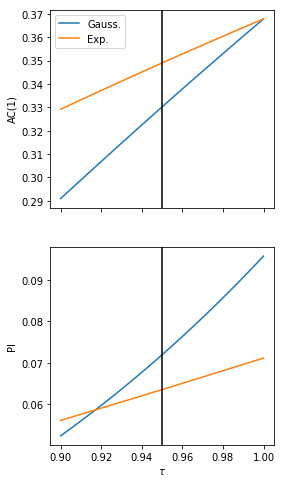

In [19]:
tau = .95
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax1.plot(taus, gauss_ac1, label='Gauss.')
ax1.plot(taus, exp_ac1, label='Exp.')
ax1.set_ylabel('AC(1)')
ax1.axvline(tau, 0, 1, c='k')
ax1.legend(loc='best')

ax2.plot(taus, gauss_pi)
ax2.plot(taus, exp_pi)
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel('PI')
ax2.axvline(tau, 0, 1, c='k')

In [20]:
n_samples = 1000
GP1_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau)
GP2_ker = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
X1 = synth_data.sample_gp(n_samples, 1, GP1_ker, num_to_concat=10) * 2.
X2 = synth_data.sample_gp(n_samples, 1, GP2_ker, num_to_concat=10)
#X2 = np.random.randn(n_samples, 1)
X = np.concatenate([X1, X2], axis=1)

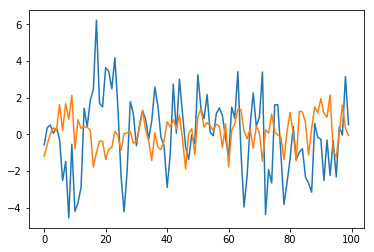

In [21]:
plt.plot(X1[:100])
plt.plot(X2[:100])

In [22]:
reload(mc)
sfa_model = mc.SlowFeatureAnalysis(1).fit(X)
print(sfa_model.coef_)

[[-0.08550661]
 [-0.9963376 ]]


In [23]:
cca_model = CCA(d=1, T=1, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.08314083]
 [-0.99653781]]


In [24]:
cca_model = CCA(d=1, T=2, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.9960485 ]
 [-0.08881093]]


# Comparison with GPFA

In [2]:
def gen_gp_concat_noise(n_samples, n_concat):
    GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=1., local_noise=.001)
    X1 = synth_data.sample_gp(n_samples, 1, GP_ker, num_to_concat=n_concat)
    GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=2., local_noise=.001)
    X2 = synth_data.sample_gp(n_samples, 1, GP_ker, num_to_concat=n_concat)
    mu = np.zeros(4)
    cov = np.diag([10, 8, 2, 1])
    X3 = np.random.multivariate_normal(mu, cov, size=n_samples * n_concat)
    X = np.concatenate([X1, X2, X3], axis=1)
    return X

In [10]:
n_samples = 100
n_concat = 2
X = gen_gp_concat_noise(n_samples, n_concat)
Xtest = gen_gp_concat_noise(n_samples, n_concat)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [11]:
reload(mc)
gpfa1 = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=2)

In [12]:
gpfa1.fit(X)

FA log likelihood: -3403.548596023145
Pre update log likelihood: -3403.5485960231445
C_ update log likelihood: -3396.30845042951
d_ update log likelihood: -3396.306260644449
Exact update log likelihood: -2260.3482534942987
tau opt 602.3936554017465
tau opt 520.6095232730395
tau opt 604.338780240184
tau opt 606.2895214908432
tau opt 606.5907483244929
tau opt 606.7797416255636
tau opt 606.786285899383
tau opt 606.7863653509612
tau opt 606.7863654310929
tau update log likelihood: -2260.5111608356865
EM update log likelihood: -2260.5111608356865

Pre update log likelihood: -2260.5111608356865
C_ update log likelihood: -2239.698023628962
d_ update log likelihood: -2239.695693939526
Exact update log likelihood: -2237.405057819681
tau opt 622.4986312346435
tau opt -2899.0555128832198
tau opt 622.4999983282529
tau opt 622.510721217508
tau opt 622.5107218126047
tau update log likelihood: -2237.4519516322316
EM update log likelihood: -2237.4519516322316

Pre update log likelihood: -2237.45195163

C_ update log likelihood: -2219.0387716029513
d_ update log likelihood: -2219.0380830986114
Exact update log likelihood: -2219.035372035042
tau opt 579.3642641708727
tau opt 453.5882676015864
tau opt 579.2264589000426
tau opt 579.5463634214499
tau opt 579.5464416109963
tau opt 579.5464464351492
tau opt 579.5464464352231
tau update log likelihood: -2218.647500149587
EM update log likelihood: -2218.647500149587

Pre update log likelihood: -2218.647500149587
C_ update log likelihood: -2218.615532137019
d_ update log likelihood: -2218.614946153986
Exact update log likelihood: -2218.6114764640274
tau opt 577.0940569482451
tau opt 449.66326256950776
tau opt 576.9470706441709
tau opt 577.2897397052955
tau opt 577.2898117818171
tau opt 577.2898167312126
tau opt 577.2898167313383
tau update log likelihood: -2218.193461802471
EM update log likelihood: -2218.193461802471

Pre update log likelihood: -2218.193461802471
C_ update log likelihood: -2218.159638514002
d_ update log likelihood: -2218.159

C_ update log likelihood: -2205.010670613987
d_ update log likelihood: -2205.0103237909416
Exact update log likelihood: -2204.9869058917493
tau opt 523.2110988025934
tau opt 349.1085530927701
tau opt 523.032586606273
tau opt 523.5708085977119
tau opt 523.5708124287642
tau opt 523.5708131777743
tau update log likelihood: -2204.2352196150096
EM update log likelihood: -2204.2352196150096

Pre update log likelihood: -2204.2352196150096
C_ update log likelihood: -2204.1997472777957
d_ update log likelihood: -2204.199328525012
Exact update log likelihood: -2204.178690970417
tau opt 519.7944691655503
tau opt 342.28256573968497
tau opt 519.6176006052704
tau opt 520.1401756024894
tau opt 520.1401789592278
tau opt 520.1401796453388
tau update log likelihood: -2203.455025915815
EM update log likelihood: -2203.455025915815

Pre update log likelihood: -2203.455025915815
C_ update log likelihood: -2203.4221873701035
d_ update log likelihood: -2203.4217073630916
Exact update log likelihood: -2203.403

tau opt 445.1394765873762
tau update log likelihood: -2184.1996584802678
EM update log likelihood: -2184.1996584802678

Pre update log likelihood: -2184.1996584802678
C_ update log likelihood: -2184.113082626007
d_ update log likelihood: -2184.112646330658
Exact update log likelihood: -2183.920243357161
tau opt 437.90313140948905
tau opt 194.20801146381473
tau opt 438.05766775568065
tau opt 438.7131639773138
tau opt 438.72368513102214
tau opt 438.7238544912444
tau opt 438.72385526259154
tau update log likelihood: -2182.092722394853
EM update log likelihood: -2182.092722394853

Pre update log likelihood: -2182.092722394853
C_ update log likelihood: -2181.9978439477522
d_ update log likelihood: -2181.99742425796
Exact update log likelihood: -2181.767493415045
tau opt 431.1180465897176
tau opt 184.6852165528207
tau opt 431.367282172138
tau opt 431.9864548849547
tau opt 431.996764782727
tau opt 431.9969174557808
tau opt 431.996918581611
tau opt 431.99691909714863
tau update log likelihood:

Pre update log likelihood: -2124.198617417433
C_ update log likelihood: -2124.1702316246283
d_ update log likelihood: -2124.1701406116017
Exact update log likelihood: -2121.3156948689975
tau opt 293.380277952018
tau opt 84.75562912673152
tau opt 293.13050525915116
tau opt 294.82017441694745
tau opt 294.82067206582167
tau opt 294.821237027773
tau opt 294.8212371929178
tau update log likelihood: -2118.034853485095
EM update log likelihood: -2118.034853485095

Pre update log likelihood: -2118.034853485095
C_ update log likelihood: -2118.0175573372953
d_ update log likelihood: -2118.0174675512544
Exact update log likelihood: -2114.806177737835
tau opt 283.2750964642564
tau opt 80.88336595796264
tau opt 282.79171773055623
tau opt 284.56456088180096
tau opt 284.56508147370573
tau opt 284.5656819053272
tau opt 284.5656821934358
tau update log likelihood: -2111.899401968768
EM update log likelihood: -2111.899401968768

Pre update log likelihood: -2111.899401968768
C_ update log likelihood: -21

tau update log likelihood: -2069.3089540916453
EM update log likelihood: -2069.3089540916453

Pre update log likelihood: -2069.3089540916453
C_ update log likelihood: -2069.2990178484806
d_ update log likelihood: -2069.2989989102716
Exact update log likelihood: -2068.8299279858957
tau opt 229.42107456691934
tau opt 22.54947629764159
tau opt 229.41945680232624
tau opt 229.42364168086155
tau opt 229.4244388648908
tau opt 229.4248060816101
tau opt 229.42480609674266
tau update log likelihood: -2068.821774174277
EM update log likelihood: -2068.821774174277

Pre update log likelihood: -2068.821774174277
C_ update log likelihood: -2068.8124904654615
d_ update log likelihood: -2068.812472878458
Exact update log likelihood: -2068.411023655157
tau opt 228.85324269910805
tau opt 20.858985615134486
tau opt 228.85206847185216
tau opt 228.8557239420466
tau opt 228.8565417539472
tau opt 228.85687147847221
tau opt 228.85687149123058
tau update log likelihood: -2068.403136760412
EM update log likeliho

tau update log likelihood: -2065.704028041243
EM update log likelihood: -2065.704028041243

Pre update log likelihood: -2065.704028041243
C_ update log likelihood: -2065.699259123476
d_ update log likelihood: -2065.699250658272
Exact update log likelihood: -2065.6452751766624
tau opt 220.7958171998363
tau opt 28.37917235979978
tau opt 220.79685007816053
tau opt 220.7992025261734
tau opt 220.79924053441962
tau opt 220.79924126456535
tau opt 220.79924126465994
tau update log likelihood: -2065.638221059356
EM update log likelihood: -2065.638221059356

Pre update log likelihood: -2065.638221059356
C_ update log likelihood: -2065.633558929024
d_ update log likelihood: -2065.6335506825717
Exact update log likelihood: -2065.584200169802
tau opt 220.3784665930291
tau opt 30.086072482032336
tau opt 220.37948988776927
tau opt 220.38184951682499
tau opt 220.38190701580334
tau opt 220.38190792853325
tau opt 220.3819079286179
tau update log likelihood: -2065.577120160962
EM update log likelihood: -

tau update log likelihood: -2064.964447483508
EM update log likelihood: -2064.964447483508

Pre update log likelihood: -2064.964447483508
C_ update log likelihood: -2064.9608842820703
d_ update log likelihood: -2064.9608783830026
Exact update log likelihood: -2064.9467375850427
tau opt 213.68704839397816
tau opt 54.69291891456044
tau opt 213.68649432321686
tau opt 213.6905812807415
tau opt 213.6904521872862
tau opt 213.6908282980261
tau opt 213.69082830249963
tau update log likelihood: -2064.9390562000963
EM update log likelihood: -2064.9390562000963

Pre update log likelihood: -2064.9390562000963
C_ update log likelihood: -2064.935532824908
d_ update log likelihood: -2064.9355270155124
Exact update log likelihood: -2064.922228220622
tau opt 213.30842913088878
tau opt 55.5843663956187
tau opt 213.30773841800678
tau opt 213.3119929570904
tau opt 213.31184760676956
tau opt 213.31222704483147
tau opt 213.31222704888944
tau update log likelihood: -2064.9145131166783
EM update log likelihoo

tau update log likelihood: -2064.598981890849
EM update log likelihood: -2064.598981890849

Pre update log likelihood: -2064.598981890849
C_ update log likelihood: -2064.5959527947134
d_ update log likelihood: -2064.5959481111245
Exact update log likelihood: -2064.5906119916826
tau opt 206.98661160653575
tau opt 62.01790528883606
tau opt 206.98395641498894
tau opt 206.99052380791252
tau opt 206.99034500151225
tau opt 206.99062419176857
tau opt 206.99062419257388
tau update log likelihood: -2064.582495317127
EM update log likelihood: -2064.582495317127

Pre update log likelihood: -2064.582495317127
C_ update log likelihood: -2064.579487792736
d_ update log likelihood: -2064.5794831575804
Exact update log likelihood: -2064.574394762372
tau opt 206.61950077684628
tau opt 62.00271076085869
tau opt 206.6167622418088
tau opt 206.6234244428568
tau opt 206.62325006956038
tau opt 206.62352036233656
tau opt 206.62352036306652
tau update log likelihood: -2064.5662653073437
EM update log likelihoo

tau update log likelihood: -2064.3327354146268
EM update log likelihood: -2064.3327354146268

Pre update log likelihood: -2064.3327354146268
C_ update log likelihood: -2064.3300195795027
d_ update log likelihood: -2064.3300155684774
Exact update log likelihood: -2064.327575108007
tau opt 200.42925327269762
tau opt 58.05518119335437
tau opt 200.42557259314137
tau opt 200.43326929768762
tau opt 200.43317039664655
tau opt 200.43331673077947
tau opt 200.43331673094033
tau update log likelihood: -2064.3193743625243
EM update log likelihood: -2064.3193743625243

Pre update log likelihood: -2064.3193743625243
C_ update log likelihood: -2064.3166721448492
d_ update log likelihood: -2064.3166681610237
Exact update log likelihood: -2064.3143224503106
tau opt 200.06759059607066
tau opt 57.66843262467853
tau opt 200.06387623287912
tau opt 200.0716076886312
tau opt 200.07151240414913
tau opt 200.07165336832585
tau opt 200.07165336847015
tau update log likelihood: -2064.306123815478
EM update log li

tau update log likelihood: -2064.1061483567664
EM update log likelihood: -2064.1061483567664

Pre update log likelihood: -2064.1061483567664
C_ update log likelihood: -2064.1036352107994
d_ update log likelihood: -2064.103631581149
Exact update log likelihood: -2064.1023787343747
tau opt 193.94642198994933
tau opt 49.66446497242569
tau opt 193.9423408677779
tau opt 193.95042943462846
tau opt 193.95037918318798
tau opt 193.95045484316154
tau opt 193.95045484320025
tau update log likelihood: -2064.094249086028
EM update log likelihood: -2064.094249086028

Pre update log likelihood: -2064.094249086028
C_ update log likelihood: -2064.0917449623716
d_ update log likelihood: -2064.091741348486
Exact update log likelihood: -2064.0905310445114
tau opt 193.58738226444248
tau opt 49.13138312646103
tau opt 193.5832878669733
tau opt 193.5913887005404
tau opt 193.59134028795117
tau opt 193.5914133177509
tau opt 193.5914133177939
tau update log likelihood: -2064.0824053496694
EM update log likelihoo

tau update log likelihood: -2063.8988912979153
EM update log likelihood: -2063.8988912979153

Pre update log likelihood: -2063.8988912979153
C_ update log likelihood: -2063.896514289514
d_ update log likelihood: -2063.89651088706
Exact update log likelihood: -2063.8958166877865
tau opt 187.47919609632663
tau opt 39.41378591662419
tau opt 187.47493519675518
tau opt 187.48320519998023
tau opt 187.48317911064868
tau opt 187.48322017155928
tau opt 187.4832201715801
tau update log likelihood: -2063.887708369549
EM update log likelihood: -2063.887708369549

Pre update log likelihood: -2063.887708369549
C_ update log likelihood: -2063.8853375208078
d_ update log likelihood: -2063.8853341281147
Exact update log likelihood: -2063.8846611525
tau opt 187.11879821080132
tau opt 38.810674690407325
tau opt 187.11452930770164
tau opt 187.12280922144208
tau opt 187.12278403934818
tau opt 187.12282379290647
tau opt 187.12282379292
tau update log likelihood: -2063.8765498854023
EM update log likelihood:

tau update log likelihood: -2063.700251234206
EM update log likelihood: -2063.700251234206

Pre update log likelihood: -2063.700251234206
C_ update log likelihood: -2063.6979681107914
d_ update log likelihood: -2063.6979648525808
Exact update log likelihood: -2063.6975585503233
tau opt 180.94483594828344
tau opt 28.14465698037867
tau opt 180.9404272586615
tau opt 180.9489208306494
tau opt 180.94890682424747
tau opt 180.9489303115293
tau opt 180.9489303115271
tau opt 180.94893031152455
tau opt 180.94893031152588
tau opt 180.94893031152645
tau opt 180.9489303115293
tau opt 180.9489303115293
tau opt 180.94893031152378
tau opt 180.9489303115293
tau opt 180.9489303115293
tau opt 180.9489303115217
tau opt 180.9489303115293
tau opt 180.9489303115293
tau opt 180.94893031152202
tau opt 180.9489303115293
tau opt 180.9489303115293
tau opt 180.9489303115311
tau opt 180.9489303115311
tau opt 180.9489303115311
tau opt 180.94893031152557
tau opt 180.9489303115311
tau opt 180.94892727138637
tau opt 18

tau opt 176.88100637644544
tau opt 176.88100637645329
tau opt 176.88100637644482
tau opt 176.88100637645329
tau update log likelihood: -2063.5688387769123
EM update log likelihood: -2063.5688387769123

Pre update log likelihood: -2063.5688387769123
C_ update log likelihood: -2063.566601904601
d_ update log likelihood: -2063.5665987137854
Exact update log likelihood: -2063.5663074399604
tau opt 176.50313992876377
tau opt 20.188932334228497
tau opt 176.4986110081925
tau opt 176.50732965050142
tau opt 176.5073202652746
tau opt 176.50733686564357
tau opt 176.5073368656507
tau update log likelihood: -2063.5578502526655
EM update log likelihood: -2063.5578502526655

Pre update log likelihood: -2063.5578502526655
C_ update log likelihood: -2063.5556167567943
d_ update log likelihood: -2063.5556135707884
Exact update log likelihood: -2063.55533004114
tau opt 176.12873522514067
tau opt 19.5103507310765
tau opt 176.12419510711587
tau opt 176.1329357623062
tau opt 176.13292668099302
tau opt 176.1

C_ update log likelihood: -2063.4227047939758
d_ update log likelihood: -2063.4227016574587
Exact update log likelihood: -2063.422494601111
tau opt 171.5734042394669
tau opt 11.181620274749264
tau opt 171.56871351822946
tau opt 171.5777596591959
tau opt 171.5777535351029
tau opt 171.57776515194143
tau opt 171.57776515193893
tau opt 171.57776515194766
tau opt 171.5777651519337
tau opt 171.57776515194766
tau update log likelihood: -2063.413705480216
EM update log likelihood: -2063.413705480216

Pre update log likelihood: -2063.413705480216
C_ update log likelihood: -2063.411510152747
d_ update log likelihood: -2063.411507019719
Exact update log likelihood: -2063.4113051663194
tau opt 171.18806498826277
tau opt 10.471696876707966
tau opt 171.183360346794
tau opt 171.19243538953273
tau opt 171.1924294633293
tau opt 171.19244077233614
tau opt 171.19244077233967
tau update log likelihood: -2063.4024858878383
EM update log likelihood: -2063.4024858878383

Pre update log likelihood: -2063.4024

Exact update log likelihood: -2063.2286588013694
tau opt 164.88096396772133
tau opt -1.2436725205940036
tau opt 164.8760095031928
tau opt 164.88561565334402
tau opt 164.88561215580637
tau opt 164.88561961186576
tau update log likelihood: -2063.2192731352607
EM update log likelihood: -2063.2192731352607

Pre update log likelihood: -2063.2192731352607
C_ update log likelihood: -2063.217114304328
d_ update log likelihood: -2063.217111217623
Exact update log likelihood: -2063.2169779321557
tau opt 164.4771121647091
tau opt -1.998841181178875
tau opt 164.47214047846379
tau opt 164.48178391515276
tau opt 164.48178053247838
tau opt 164.48178780159552
tau update log likelihood: -2063.207551817446
EM update log likelihood: -2063.207551817446

Pre update log likelihood: -2063.207551817446
C_ update log likelihood: -2063.205394745404
d_ update log likelihood: -2063.205391660712
Exact update log likelihood: -2063.2052614513823
tau opt 164.0720333848411
tau opt -2.7568143739503626
tau opt 164.06704

d_ update log likelihood: -2063.0495087718455
Exact update log likelihood: -2063.0494115314345
tau opt 158.68806604391114
tau opt -12.87317660583507
tau opt 158.68283699944504
tau opt 158.69304587539287
tau opt 158.69304377922555
tau opt 158.69304890706678
tau opt 158.69304890706846
tau update log likelihood: -2063.0393642176914
EM update log likelihood: -2063.0393642176914

Pre update log likelihood: -2063.0393642176914
C_ update log likelihood: -2063.037228283315
d_ update log likelihood: -2063.0372252192174
Exact update log likelihood: -2063.0371300492016
tau opt 158.2643863001622
tau opt -13.672118373555165
tau opt 158.25913789287483
tau opt 158.26938990706012
tau opt 158.26938788352487
tau opt 158.269392887123
tau opt 158.26939288712836
tau update log likelihood: -2063.027034791123
EM update log likelihood: -2063.027034791123

Pre update log likelihood: -2063.027034791123
C_ update log likelihood: -2063.024900157606
d_ update log likelihood: -2063.024897094455
Exact update log lik

tau update log likelihood: -2062.8754374101627
EM update log likelihood: -2062.8754374101627

Pre update log likelihood: -2062.8754374101627
C_ update log likelihood: -2062.8733169834973
d_ update log likelihood: -2062.8733139264755
Exact update log likelihood: -2062.8732410029606
tau opt 152.62321771503176
tau opt -24.34047016752062
tau opt 152.61771046610392
tau opt 152.62854745298674
tau opt 152.62854619956897
tau opt 152.6285498510359
tau opt 152.62854985103502
tau opt 152.62854985102814
tau opt 152.6285498510332
tau opt 152.6285498510359
tau opt 152.6285498510359
tau opt 152.6285498510323
tau opt 152.6285498510359
tau opt 152.6285498510359
tau opt 152.62854985104042
tau opt 152.62854985104042
tau opt 152.62854985104042
tau opt 152.62854985103758
tau opt 152.62854985104042
tau opt 152.62854985104042
tau opt 152.62854985103726
tau opt 152.62854985104042
tau opt 152.62854985104042
tau opt 152.6285498510324
tau opt 152.62854985104042
tau opt 152.62854985104042
tau opt 152.628549230020

Pre update log likelihood: -2062.716672307357
C_ update log likelihood: -2062.7145649630925
d_ update log likelihood: -2062.714561902816
Exact update log likelihood: -2062.714503433233
tau opt 147.1843961488249
tau opt -34.66850446289807
tau opt 147.17864686736664
tau opt 147.19004692550627
tau opt 147.19004616082455
tau opt 147.1900489045945
tau opt 147.19004890459763
tau update log likelihood: -2062.7031039544063
EM update log likelihood: -2062.7031039544063

Pre update log likelihood: -2062.7031039544063
C_ update log likelihood: -2062.700997718433
d_ update log likelihood: -2062.700994657475
Exact update log likelihood: -2062.700937185254
tau opt 146.7207139411983
tau opt -35.55051774497123
tau opt 146.7149447447304
tau opt 146.72639196465437
tau opt 146.72639123331876
tau opt 146.72639391299023
tau opt 146.7263939129897
tau opt 146.72639391299057
tau update log likelihood: -2062.6894827531064
EM update log likelihood: -2062.6894827531064

Pre update log likelihood: -2062.689482753

C_ update log likelihood: -2062.5624114621355
d_ update log likelihood: -2062.562408390997
Exact update log likelihood: -2062.562359453026
tau opt 141.9933762016146
tau opt -44.55346117208656
tau opt 141.98741264531807
tau opt 141.99932813122052
tau opt 141.99932768332556
tau opt 141.99932980053302
tau opt 141.99932980053492
tau update log likelihood: -2062.5503539593433
EM update log likelihood: -2062.5503539593433

Pre update log likelihood: -2062.5503539593433
C_ update log likelihood: -2062.548260739656
d_ update log likelihood: -2062.5482576671748
Exact update log likelihood: -2062.5482094523645
tau opt 141.51152032866662
tau opt -45.47215947623614
tau opt 141.50553793588006
tau opt 141.51749966467068
tau opt 141.5174992406135
tau opt 141.51750130887757
tau opt 141.517501308882
tau update log likelihood: -2062.5361488413446
EM update log likelihood: -2062.5361488413446

Pre update log likelihood: -2062.5361488413446
C_ update log likelihood: -2062.534056909435
d_ update log likeli

tau opt 136.10672256220042
tau opt 136.10672256219578
tau opt 136.10672256219974
tau opt 136.10672256219775
tau opt 136.1067225621931
tau opt 136.10672256220042
tau opt 136.10672256220042
tau opt 136.10672256219286
tau opt 136.10672256220042
tau opt 136.10672256220042
tau opt 136.10672256220118
tau opt 136.10672256220118
tau opt 136.10672256220118
tau opt 136.10672256220226
tau opt 136.10672256220226
tau opt 136.10672256220226
tau opt 136.1067225622011
tau opt 136.10672256220226
tau opt 136.10672256220226
tau opt 136.10672256220226
tau opt 136.10672256220226
tau update log likelihood: -2062.37640319152
EM update log likelihood: -2062.37640319152

Pre update log likelihood: -2062.37640319152
C_ update log likelihood: -2062.3743270179293
d_ update log likelihood: -2062.374323925016
Exact update log likelihood: -2062.374282826031
tau opt 135.5984276280723
tau opt -56.7573257102606
tau opt 135.59222938567066
tau opt 135.604733376651
tau opt 135.6047331880839
tau opt 135.6047347496742
tau o

Pre update log likelihood: -2062.194948393226
C_ update log likelihood: -2062.192893252247
d_ update log likelihood: -2062.192890131939
Exact update log likelihood: -2062.1928536698474
tau opt 129.44232609336677
tau opt -68.52482160089188
tau opt 129.4359284649223
tau opt 129.44895203804526
tau opt 129.4489520097346
tau opt 129.4489531890625
tau opt 129.44895318906882
tau update log likelihood: -2062.1794937933855
EM update log likelihood: -2062.1794937933855

Pre update log likelihood: -2062.1794937933855
C_ update log likelihood: -2062.1774405908727
d_ update log likelihood: -2062.1774374680235
Exact update log likelihood: -2062.177401292851
tau opt 128.9182797933639
tau opt -69.52726370089349
tau opt 128.91186587003003
tau opt 128.92493223420504
tau opt 128.9249322165563
tau opt 128.92493336863825
tau opt 128.92493336863618
tau opt 128.92493336863816
tau opt 128.92493336864308
tau opt 128.9249333686396
tau opt 128.92493336864308
tau update log likelihood: -2062.163988022057
EM updat

C_ update log likelihood: -2062.0040892829434
d_ update log likelihood: -2062.00408613013
Exact update log likelihood: -2062.004052138889
tau opt 123.04021272618743
tau opt -80.77764751300711
tau opt 123.03361221688374
tau opt 123.04715844184213
tau opt 123.04715851972693
tau opt 123.04715940901002
tau opt 123.04715940901607
tau update log likelihood: -2061.9900494943654
EM update log likelihood: -2061.9900494943654

Pre update log likelihood: -2061.9900494943654
C_ update log likelihood: -2061.988021449937
d_ update log likelihood: -2061.9880182942543
Exact update log likelihood: -2061.9879844132392
tau opt 122.49540679758064
tau opt -81.82106092287857
tau opt 122.48878784538772
tau opt 122.50237963475686
tau opt 122.50237971955656
tau opt 122.50238058819548
tau opt 122.50238058820409
tau update log likelihood: -2061.9739271971566
EM update log likelihood: -2061.9739271971566

Pre update log likelihood: -2061.9739271971566
C_ update log likelihood: -2061.971901382374
d_ update log lik

tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882059
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882684
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882735
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882738
tau opt 115.8243196788317
tau opt 115.82431704336605
tau opt 115.82431967882806
tau opt 115.82431967882826
tau opt 115.82431967882326
tau opt 115.82431967882684
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882735
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.8243196788255
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882707
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.8243196788317
tau opt 115.82431967882707
tau update log likelihood: -2061.7762408539265
EM update log likelihood: -2061.7762408539265

Pre update log likelihood: -2061.776

tau update log likelihood: -2061.5522874854814
EM update log likelihood: -2061.5522874854814

Pre update log likelihood: -2061.5522874854814
C_ update log likelihood: -2061.5503209038943
d_ update log likelihood: -2061.5503176714246
Exact update log likelihood: -2061.5502809110594
tau opt 107.67321572950246
tau opt -110.73024879098777
tau opt 107.66589169345977
tau opt 107.6810044860668
tau opt 107.68100503289827
tau opt 107.68100634555122
tau update log likelihood: -2061.534573333708
EM update log likelihood: -2061.534573333708

Pre update log likelihood: -2061.534573333708
C_ update log likelihood: -2061.532607073286
d_ update log likelihood: -2061.532603836721
Exact update log likelihood: -2061.532566415593
tau opt 107.07433694654526
tau opt -111.48756618890022
tau opt 107.06691662384037
tau opt 107.08216424427346
tau opt 107.08216448286797
tau opt 107.08216504345609
tau update log likelihood: -2061.5167824012055
EM update log likelihood: -2061.5167824012055

Pre update log likeliho

Pre update log likelihood: -2061.2003657454825
C_ update log likelihood: -2061.1984318120226
d_ update log likelihood: -2061.198428522941
Exact update log likelihood: -2061.1983784868266
tau opt 95.87949611644771
tau opt -133.06670881124595
tau opt 95.87142161408212
tau opt 95.88821731101893
tau opt 95.88821755451056
tau opt 95.8882178905339
tau update log likelihood: -2061.1807769600127
EM update log likelihood: -2061.1807769600127

Pre update log likelihood: -2061.1807769600127
C_ update log likelihood: -2061.178844117866
d_ update log likelihood: -2061.178840825847
Exact update log likelihood: -2061.1787896929786
tau opt 95.2301698722278
tau opt -134.28927699009785
tau opt 95.2220865115469
tau opt 95.23895459539713
tau opt 95.23895480868288
tau opt 95.23895509556536
tau update log likelihood: -2061.161058885838
EM update log likelihood: -2061.161058885838

Pre update log likelihood: -2061.161058885838
C_ update log likelihood: -2061.1591272382384
d_ update log likelihood: -2061.1591

Pre update log likelihood: -2060.801636216903
C_ update log likelihood: -2060.799710492284
d_ update log likelihood: -2060.799707151489
Exact update log likelihood: -2060.799625856105
tau opt 82.90806404087547
tau opt -157.6677223517203
tau opt 82.90130253429473
tau opt 82.91838669808376
tau opt 82.91838689441695
tau opt 82.91838706424292
tau update log likelihood: -2060.778757117849
EM update log likelihood: -2060.778757117849

Pre update log likelihood: -2060.778757117849
C_ update log likelihood: -2060.776830575096
d_ update log likelihood: -2060.7768272316935
Exact update log likelihood: -2060.776743462383
tau opt 82.18234403946138
tau opt -159.00917434722794
tau opt 82.17574582281205
tau opt 82.19277976414531
tau opt 82.19277995933811
tau opt 82.19278012428319
tau update log likelihood: -2060.7556437493727
EM update log likelihood: -2060.7556437493727

Pre update log likelihood: -2060.7556437493727
C_ update log likelihood: -2060.753716218247
d_ update log likelihood: -2060.753712

Pre update log likelihood: -2060.3181535075437
C_ update log likelihood: -2060.3161733844
d_ update log likelihood: -2060.31616999591
Exact update log likelihood: -2060.316016262468
tau opt 68.12245669546212
tau opt -183.6749112643888
tau opt 68.12011516646729
tau opt 68.13569621328531
tau opt 68.135696381517
tau opt 68.13569647523593
tau update log likelihood: -2060.289181086418
EM update log likelihood: -2060.289181086418

Pre update log likelihood: -2060.289181086418
C_ update log likelihood: -2060.2871950219096
d_ update log likelihood: -2060.2871916310273
Exact update log likelihood: -2060.287032052651
tau opt 67.2759803183084
tau opt -185.06710692106262
tau opt 67.27393151749288
tau opt 67.28942979162548
tau opt 67.28942995804906
tau opt 67.28943004862799
tau update log likelihood: -2060.259766875115
EM update log likelihood: -2060.259766875115

Pre update log likelihood: -2060.259766875115
C_ update log likelihood: -2060.257774446878
d_ update log likelihood: -2060.257771053616


tau update log likelihood: -2059.674518007604
EM update log likelihood: -2059.674518007604

Pre update log likelihood: -2059.674518007604
C_ update log likelihood: -2059.672327380529
d_ update log likelihood: -2059.672323949212
Exact update log likelihood: -2059.6719920450396
tau opt 50.427461447075046
tau opt -210.35638082105106
tau opt 50.431418759322355
tau opt 50.44622359994929
tau opt 50.44622849814556
tau opt 50.44622852092584
tau update log likelihood: -2059.633822207272
EM update log likelihood: -2059.633822207272

Pre update log likelihood: -2059.633822207272
C_ update log likelihood: -2059.6316126424244
d_ update log likelihood: -2059.631609208984
Exact update log likelihood: -2059.631262382006
tau opt 49.38501777358488
tau opt -211.76830870956908
tau opt 49.389352809175136
tau opt 49.40418502468424
tau opt 49.40419001289203
tau opt 49.40419003449722
tau update log likelihood: -2059.5922598297116
EM update log likelihood: -2059.5922598297116

Pre update log likelihood: -2059.

tau opt 29.341117771390913
tau update log likelihood: -2058.7161383075427
EM update log likelihood: -2058.7161383075427

Pre update log likelihood: -2058.7161383075427
C_ update log likelihood: -2058.713334639422
d_ update log likelihood: -2058.713331166729
Exact update log likelihood: -2058.7125211786843
tau opt 27.96804191215753
tau opt -237.22114595339997
tau opt 27.980297654796743
tau opt 27.997669468913926
tau opt 27.997677681735496
tau opt 27.99767769058198
tau update log likelihood: -2058.6519704768425
EM update log likelihood: -2058.6519704768425

Pre update log likelihood: -2058.6519704768425
C_ update log likelihood: -2058.6491142088926
d_ update log likelihood: -2058.649110733562
Exact update log likelihood: -2058.64825908072
tau opt 26.602474629088476
tau opt -238.6329851690772
tau opt 26.615240964986356
tau opt 26.632910027877784
tau opt 26.63291856093656
tau opt 26.632918569470917
tau update log likelihood: -2058.5860409985276
EM update log likelihood: -2058.5860409985276

Exact update log likelihood: -2057.2206265119694
tau opt -0.48835027168001943
tau opt -262.3974388322621
tau opt -0.4663298114012946
tau opt -0.43853272282194666
tau opt -0.4385129079853698
tau opt -0.4385128982044364
tau opt -0.4385128980312345
tau update log likelihood: -2057.1182957444275
EM update log likelihood: -2057.1182957444275

Pre update log likelihood: -2057.1182957444275
C_ update log likelihood: -2057.113841886709
d_ update log likelihood: -2057.1138382890767
Exact update log likelihood: -2057.1116233473485
tau opt -2.3501429658935535
tau opt -263.77241710704334
tau opt -2.327625435443025
tau opt -2.2987755973563253
tau opt -2.298754531637968
tau opt -2.2987545211929046
tau opt -2.2987545210467033
tau update log likelihood: -2057.0060776208716
EM update log likelihood: -2057.0060776208716

Pre update log likelihood: -2057.0060776208716
C_ update log likelihood: -2057.0014859119783
d_ update log likelihood: -2057.0014822965873
Exact update log likelihood: -2056.99913989657

/Users/jesse/Development/ComplexityComponentsAnalysis/cca/methods_comparison.py:456: ConvergenceWarning: EM max_iter reached.
  warnings.warn("EM max_iter reached.", ConvergenceWarning)


In [13]:
Xp = X.reshape(n_concat, -1, X.shape[-1])

In [14]:
gpfa2 = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=2)

In [15]:
gpfa2.fit(Xp)

FA log likelihood: -3400.7666692983594
Pre update log likelihood: -3400.7666692983594
C_ update log likelihood: -3393.6057382784156
d_ update log likelihood: -3393.6040760771807
Exact update log likelihood: -2260.7185514799203
tau opt 593.1297679885464
tau opt 515.4643427723763
tau opt 595.3402598092566
tau opt 597.3310539145648
tau opt 597.6860480806472
tau opt 597.8647239408765
tau opt 597.8711079773014
tau opt 597.8711768987794
tau opt 597.8711769430146
tau update log likelihood: -2260.89436682006
EM update log likelihood: -2260.89436682006

Pre update log likelihood: -2260.89436682006
C_ update log likelihood: -2240.0817956337514
d_ update log likelihood: -2240.077842837918
Exact update log likelihood: -2237.966042317043
tau opt 613.2825996118286
tau opt -1615.6855700204978
tau opt 613.2894916189944
tau opt 613.3107579497786
tau opt 613.3107948059657
tau opt 613.3107948552774
tau update log likelihood: -2237.982318623611
EM update log likelihood: -2237.982318623611

Pre update log 

tau update log likelihood: -2215.235894711619
EM update log likelihood: -2215.235894711619

Pre update log likelihood: -2215.235894711619
C_ update log likelihood: -2215.2248483170315
d_ update log likelihood: -2215.22344270688
Exact update log likelihood: -2215.216862034433
tau opt 565.2783945350172
tau opt 434.1775674881169
tau opt 565.1189603396681
tau opt 565.5424286896034
tau opt 565.5424580139969
tau opt 565.5424620520114
tau opt 565.5424620529857
tau update log likelihood: -2214.64733272165
EM update log likelihood: -2214.64733272165

Pre update log likelihood: -2214.64733272165
C_ update log likelihood: -2214.635380720553
d_ update log likelihood: -2214.634180879875
Exact update log likelihood: -2214.625432774923
tau opt 562.5168493463075
tau opt 429.0497331692791
tau opt 562.3491499337922
tau opt 562.8060347064754
tau opt 562.8060651298201
tau opt 562.8060696829202
tau opt 562.806069684304
tau update log likelihood: -2213.999518433253
EM update log likelihood: -2213.9995184332

tau update log likelihood: -2199.472849603372
EM update log likelihood: -2199.472849603372

Pre update log likelihood: -2199.472849603372
C_ update log likelihood: -2199.461930925507
d_ update log likelihood: -2199.4616691282677
Exact update log likelihood: -2199.4425640173267
tau opt 501.4486704358728
tau opt 312.19207223512444
tau opt 501.28448451127406
tau opt 501.8066693435711
tau opt 501.80675965658315
tau opt 501.8067942826551
tau opt 501.8067942858993
tau update log likelihood: -2198.6818160291878
EM update log likelihood: -2198.6818160291878

Pre update log likelihood: -2198.6818160291878
C_ update log likelihood: -2198.670788652549
d_ update log likelihood: -2198.6705168859876
Exact update log likelihood: -2198.6498438738163
tau opt 497.6144978579739
tau opt 304.8839351297007
tau opt 497.44530300993927
tau opt 497.9825518433903
tau opt 497.9826505211852
tau opt 497.9826901417451
tau opt 497.98269014548646
tau update log likelihood: -2197.864504371498
EM update log likelihood: 

C_ update log likelihood: -2175.589357840928
d_ update log likelihood: -2175.5891670356073
Exact update log likelihood: -2175.2585609833704
tau opt 409.02982854480615
tau opt 161.29121618341753
tau opt 409.4843868685838
tau opt 410.0438166353642
tau opt 410.0541693634085
tau opt 410.05437714024083
tau opt 410.0544295593002
tau opt 410.05444041181846
tau opt 410.05444042623026
tau update log likelihood: -2172.952118210239
EM update log likelihood: -2172.952118210239

Pre update log likelihood: -2172.952118210239
C_ update log likelihood: -2172.8550432823836
d_ update log likelihood: -2172.854834295833
Exact update log likelihood: -2172.4614314756536
tau opt 400.97342509938585
tau opt 152.68313563384578
tau opt 401.4958434108354
tau opt 402.0576032064841
tau opt 402.06842014224685
tau opt 402.0686501970115
tau opt 402.0687187336521
tau opt 402.06873079886225
tau opt 402.0687308179897
tau update log likelihood: -2169.9904762568904
EM update log likelihood: -2169.9904762568904

Pre update 

tau opt 253.5702836370329
tau update log likelihood: -2090.212346932804
EM update log likelihood: -2090.212346932804

Pre update log likelihood: -2090.212346932804
C_ update log likelihood: -2090.201470760843
d_ update log likelihood: -2090.2009475393425
Exact update log likelihood: -2086.4633541632265
tau opt 246.71554380961743
tau opt 64.58660559273216
tau opt 246.03987234755778
tau opt 247.1462488462929
tau opt 247.14843757106462
tau opt 247.151167828155
tau opt 247.15116853363853
tau opt 247.1511685339823
tau update log likelihood: -2085.556233283034
EM update log likelihood: -2085.556233283034

Pre update log likelihood: -2085.556233283034
C_ update log likelihood: -2085.5409604335705
d_ update log likelihood: -2085.5404859069113
Exact update log likelihood: -2082.0349685088895
tau opt 241.63381119096462
tau opt 61.844819948565984
tau opt 241.1049387840589
tau opt 241.90409294435023
tau opt 241.90629261561728
tau opt 241.9090013802492
tau opt 241.90900202485463
tau opt 241.9090020

tau opt 40.01239562036169
tau opt 221.4186743061265
tau opt 221.42428266006766
tau opt 221.42462607168753
tau opt 221.42462976516452
tau opt 221.42462976547552
tau update log likelihood: -2058.9591820397236
EM update log likelihood: -2058.9591820397236

Pre update log likelihood: -2058.9591820397236
C_ update log likelihood: -2058.9520714285404
d_ update log likelihood: -2058.9519813155384
Exact update log likelihood: -2058.617232351935
tau opt 220.8242162065913
tau opt 42.35874282297452
tau opt 220.82667903299296
tau opt 220.83226780100728
tau opt 220.8327175649823
tau opt 220.8327213009062
tau opt 220.83272130106113
tau update log likelihood: -2058.5999059964693
EM update log likelihood: -2058.5999059964693

Pre update log likelihood: -2058.5999059964693
C_ update log likelihood: -2058.593182234666
d_ update log likelihood: -2058.5930967033823
Exact update log likelihood: -2058.2946319630455
tau opt 220.24031301973469
tau opt 44.538382596421435
tau opt 220.24255506734303
tau opt 220.

d_ update log likelihood: -2055.7281768449875
Exact update log likelihood: -2055.6546550768885
tau opt 211.719133066678
tau opt 62.46322057706243
tau opt 211.7173395159461
tau opt 211.72571202234656
tau opt 211.72517252465946
tau opt 211.72604393785122
tau opt 211.7260439453669
tau update log likelihood: -2055.6407068467915
EM update log likelihood: -2055.6407068467915

Pre update log likelihood: -2055.6407068467915
C_ update log likelihood: -2055.637194198027
d_ update log likelihood: -2055.63714658192
Exact update log likelihood: -2055.568397619107
tau opt 211.22887716438677
tau opt 62.78356463182979
tau opt 211.2269046149854
tau opt 211.23539587717784
tau opt 211.23486125344078
tau opt 211.23570393883975
tau opt 211.23570394535665
tau update log likelihood: -2055.554622606251
EM update log likelihood: -2055.554622606251

Pre update log likelihood: -2055.554622606251
C_ update log likelihood: -2055.551202983368
d_ update log likelihood: -2055.551156484358
Exact update log likelihood:

Pre update log likelihood: -2054.6153973127084
C_ update log likelihood: -2054.6129654419556
d_ update log likelihood: -2054.6129310587908
Exact update log likelihood: -2054.5856043150575
tau opt 203.45410348750676
tau opt 61.05641604781174
tau opt 203.45056526400595
tau opt 203.45960435635453
tau opt 203.4593296618776
tau opt 203.4597053908173
tau opt 203.45970539152145
tau update log likelihood: -2054.574328972162
EM update log likelihood: -2054.574328972162

Pre update log likelihood: -2054.574328972162
C_ update log likelihood: -2054.571938382133
d_ update log likelihood: -2054.5719045184537
Exact update log likelihood: -2054.5457635334524
tau opt 203.02464169886008
tau opt 60.68726416330086
tau opt 203.02107006587116
tau opt 203.03008855015543
tau opt 203.02982740236686
tau opt 203.03018395261637
tau opt 203.03018395325364
tau update log likelihood: -2054.5346091229453
EM update log likelihood: -2054.5346091229453

Pre update log likelihood: -2054.5346091229453
C_ update log likel

Pre update log likelihood: -2054.033555766321
C_ update log likelihood: -2054.031681493077
d_ update log likelihood: -2054.0316542391174
Exact update log likelihood: -2054.017925428733
tau opt 196.0724882842676
tau opt 52.48771438564275
tau opt 196.06874715582774
tau opt 196.07716655341522
tau opt 196.07705654656982
tau opt 196.0772067202443
tau opt 196.07720672034424
tau update log likelihood: -2054.0084363556457
EM update log likelihood: -2054.0084363556457

Pre update log likelihood: -2054.0084363556457
C_ update log likelihood: -2054.006584542574
d_ update log likelihood: -2054.006557581073
Exact update log likelihood: -2053.993268918159
tau opt 195.68085291446988
tau opt 51.93285248561873
tau opt 195.6771152467201
tau opt 195.68549455885017
tau opt 195.68538986003134
tau opt 195.68553294769902
tau opt 195.68553294778576
tau update log likelihood: -2053.983857285197
EM update log likelihood: -2053.983857285197

Pre update log likelihood: -2053.983857285197
C_ update log likelihood:

C_ update log likelihood: -2053.64703650305
d_ update log likelihood: -2053.647013516502
Exact update log likelihood: -2053.638867530851
tau opt 189.23530188930283
tau opt 41.93945785385931
tau opt 189.23168968580165
tau opt 189.23944498217793
tau opt 189.2393979382499
tau opt 189.23946412154692
tau opt 189.23946412156627
tau update log likelihood: -2053.6304986018613
EM update log likelihood: -2053.6304986018613

Pre update log likelihood: -2053.6304986018613
C_ update log likelihood: -2053.628962862531
d_ update log likelihood: -2053.6289400635064
Exact update log likelihood: -2053.620999609958
tau opt 188.86648129547922
tau opt 41.329192027793354
tau opt 188.86287800934025
tau opt 188.87060154419106
tau opt 188.87055655381158
tau opt 188.87061998545522
tau opt 188.87061998547534
tau update log likelihood: -2053.6126780222626
EM update log likelihood: -2053.6126780222626

Pre update log likelihood: -2053.6126780222626
C_ update log likelihood: -2053.611156051457
d_ update log likelih

Pre update log likelihood: -2053.357410362767
C_ update log likelihood: -2053.356072548711
d_ update log likelihood: -2053.3560524080217
Exact update log likelihood: -2053.3506896605923
tau opt 182.71554961105278
tau opt 30.7495509395576
tau opt 182.71208728156114
tau opt 182.7193687432077
tau opt 182.71934687461427
tau opt 182.71937905959703
tau opt 182.71937905959874
tau update log likelihood: -2053.34298924025
EM update log likelihood: -2053.34298924025

Pre update log likelihood: -2053.34298924025
C_ update log likelihood: -2053.341661059517
d_ update log likelihood: -2053.3416410495497
Exact update log likelihood: -2053.336389375337
tau opt 182.35921098847007
tau opt 30.11782275497793
tau opt 182.35575582907967
tau opt 182.36301692394545
tau opt 182.3629959217521
tau opt 182.3630269202152
tau opt 182.36302692022488
tau update log likelihood: -2053.3287160677182
EM update log likelihood: -2053.3287160677182

Pre update log likelihood: -2053.3287160677182
C_ update log likelihood: -

tau opt 178.11619141576378
tau opt 178.11619141576978
tau opt 178.11619141576978
tau opt 178.11619141576574
tau opt 178.11619141576978
tau update log likelihood: -2053.167491642734
EM update log likelihood: -2053.167491642734

Pre update log likelihood: -2053.167491642734
C_ update log likelihood: -2053.16627363501
d_ update log likelihood: -2053.1662551319273
Exact update log likelihood: -2053.162182571763
tau opt 177.76043630117834
tau opt 21.832912200115267
tau opt 177.75705927531226
tau opt 177.76410795526752
tau opt 177.76409532678798
tau opt 177.7641147376154
tau opt 177.7641147376106
tau opt 177.76411473762028
tau opt 177.7641147376142
tau opt 177.76411473762028
tau update log likelihood: -2053.154784832101
EM update log likelihood: -2053.154784832101

Pre update log likelihood: -2053.154784832101
C_ update log likelihood: -2053.153574283977
d_ update log likelihood: -2053.153555883835
Exact update log likelihood: -2053.149557213463
tau opt 177.4085574243402
tau opt 21.190238555

tau opt 172.8469942709875
tau opt 172.84699427098542
tau opt 172.84699427099133
tau opt 172.84699427099133
tau opt 172.84699427099196
tau opt 172.846994270996
tau opt 172.846994270996
tau opt 172.84699427098587
tau opt 172.84699427099162
tau opt 172.846994270996
tau update log likelihood: -2052.9859274961373
EM update log likelihood: -2052.9859274961373

Pre update log likelihood: -2052.9859274961373
C_ update log likelihood: -2052.9848092972584
d_ update log likelihood: -2052.9847921840014
Exact update log likelihood: -2052.9816477987256
tau opt 172.49236767542286
tau opt 12.113145696524214
tau opt 172.4890449405298
tau opt 172.4959569706254
tau opt 172.49594971471367
tau opt 172.49596149918682
tau opt 172.49596149918523
tau opt 172.4959614991879
tau opt 172.4959614991853
tau opt 172.4959614991879
tau update log likelihood: -2052.9744187194447
EM update log likelihood: -2052.9744187194447

Pre update log likelihood: -2052.9744187194447
C_ update log likelihood: -2052.9733063552744
d_ 

tau update log likelihood: -2052.8407066828227
EM update log likelihood: -2052.8407066828227

Pre update log likelihood: -2052.8407066828227
C_ update log likelihood: -2052.839657862902
d_ update log likelihood: -2052.839641735767
Exact update log likelihood: -2052.8370675158276
tau opt 167.91826949092166
tau opt 3.5411434510850626
tau opt 167.9149638947548
tau opt 167.92183786237575
tau opt 167.92183328232147
tau opt 167.9218411504176
tau update log likelihood: -2052.8298816484585
EM update log likelihood: -2052.8298816484585

Pre update log likelihood: -2052.8298816484585
C_ update log likelihood: -2052.8288376361616
d_ update log likelihood: -2052.8288215781236
Exact update log likelihood: -2052.8262846490297
tau opt 167.56510353047167
tau opt 2.875452130190766
tau opt 167.56179816849155
tau opt 167.56867198056608
tau opt 167.56866755729692
tau opt 167.56867519176137
tau update log likelihood: -2052.819098672323
EM update log likelihood: -2052.819098672323

Pre update log likelihood

Pre update log likelihood: -2052.6410358783496
C_ update log likelihood: -2052.6400680445604
d_ update log likelihood: -2052.640053096938
Exact update log likelihood: -2052.6380689512757
tau opt 161.1525854918474
tau opt -9.283102410829564
tau opt 161.14926000646864
tau opt 161.15619161048875
tau opt 161.1561892273947
tau opt 161.15619375224898
tau update log likelihood: -2052.630807486751
EM update log likelihood: -2052.630807486751

Pre update log likelihood: -2052.630807486751
C_ update log likelihood: -2052.6298433834704
d_ update log likelihood: -2052.629828491018
Exact update log likelihood: -2052.6278695671426
tau opt 160.79249715767335
tau opt -9.969166547679492
tau opt 160.7891692782623
tau opt 160.79610724208268
tau opt 160.796104938855
tau opt 160.7961093383294
tau update log likelihood: -2052.6206001163932
EM update log likelihood: -2052.6206001163932

Pre update log likelihood: -2052.6206001163932
C_ update log likelihood: -2052.6196396977384
d_ update log likelihood: -205

tau opt 155.33139565740566
tau opt 155.33139857316868
tau opt 155.33139857317298
tau update log likelihood: -2052.4694377414603
EM update log likelihood: -2052.4694377414603

Pre update log likelihood: -2052.4694377414603
C_ update log likelihood: -2052.468527695297
d_ update log likelihood: -2052.468513610069
Exact update log likelihood: -2052.4669002050427
tau opt 154.95869066925513
tau opt -21.11924534793623
tau opt 154.95530824238625
tau opt 154.9623880939851
tau opt 154.96238676057112
tau opt 154.96238959948033
tau opt 154.96238959948738
tau update log likelihood: -2052.459454760703
EM update log likelihood: -2052.459454760703

Pre update log likelihood: -2052.459454760703
C_ update log likelihood: -2052.458547783477
d_ update log likelihood: -2052.458533744444
Exact update log likelihood: -2052.4569387930405
tau opt 154.5890315290569
tau opt -21.827630260136814
tau opt 154.5856447444874
tau opt 154.59273582592368
tau opt 154.59273453763277
tau opt 154.59273730164568
tau opt 154.5

C_ update log likelihood: -2052.3789303130943
d_ update log likelihood: -2052.37891662793
Exact update log likelihood: -2052.377458442299
tau opt 151.60744526215564
tau opt -27.547485674450257
tau opt 151.60401999523134
tau opt 151.61121009600345
tau opt 151.61120912026388
tau opt 151.6112113568966
tau opt 151.61121135690271
tau update log likelihood: -2052.3698771338813
EM update log likelihood: -2052.3698771338813

Pre update log likelihood: -2052.3698771338813
C_ update log likelihood: -2052.368996426165
d_ update log likelihood: -2052.3689827833778
Exact update log likelihood: -2052.3675404273886
tau opt 151.23157079371936
tau opt -28.269330838753206
tau opt 151.22814028883093
tau opt 151.23534387021164
tau opt 151.2353429280221
tau opt 151.2353451070847
tau opt 151.23534510708544
tau update log likelihood: -2052.3599425073685
EM update log likelihood: -2052.3599425073685

Pre update log likelihood: -2052.3599425073685
C_ update log likelihood: -2052.359064580732
d_ update log like

tau opt -36.31484904412463
tau opt 147.04290143769225
tau opt 147.05026848579593
tau opt 147.05026785014743
tau opt 147.05026948991565
tau opt 147.05026948991753
tau update log likelihood: -2052.2506381360304
EM update log likelihood: -2052.2506381360304

Pre update log likelihood: -2052.2506381360304
C_ update log likelihood: -2052.2497892643732
d_ update log likelihood: -2052.249776101135
Exact update log likelihood: -2052.2485049085353
tau opt 146.66110504686546
tau opt -37.05621767062005
tau opt 146.65760485843742
tau opt 146.664988083233
tau opt 146.66498747045478
tau opt 146.66498906886147
tau opt 146.66498906887202
tau update log likelihood: -2052.2406854345436
EM update log likelihood: -2052.2406854345436

Pre update log likelihood: -2052.2406854345436
C_ update log likelihood: -2052.239839079027
d_ update log likelihood: -2052.239825953501
Exact update log likelihood: -2052.2385676030053
tau opt 146.27497468559383
tau opt -37.79930164986591
tau opt 146.27146816080807
tau opt 1

tau update log likelihood: -2052.1106897390664
EM update log likelihood: -2052.1106897390664

Pre update log likelihood: -2052.1106897390664
C_ update log likelihood: -2052.1098745653035
d_ update log likelihood: -2052.109861902216
Exact update log likelihood: -2052.1087538414795
tau opt 141.1751349408238
tau opt -47.621403012172266
tau opt 141.17153938098807
tau opt 141.1791703560557
tau opt 141.17916999739197
tau opt 141.17917112002118
tau opt 141.17917112001703
tau opt 141.17917112002294
tau opt 141.17917112002235
tau opt 141.17917112002294
tau update log likelihood: -2052.1006274261626
EM update log likelihood: -2052.1006274261626

Pre update log likelihood: -2052.1006274261626
C_ update log likelihood: -2052.0998145479666
d_ update log likelihood: -2052.0998019184512
Exact update log likelihood: -2052.0987042553597
tau opt 140.77639422188932
tau opt -48.389836518080266
tau opt 140.77279131958628
tau opt 140.78044145775482
tau opt 140.78044111329268
tau opt 140.78044220816236
tau o

Exact update log likelihood: -2051.97711977635
tau opt 135.9145019868918
tau opt -57.76361060295835
tau opt 135.9108054676443
tau opt 135.91870051918573
tau opt 135.9187003136945
tau opt 135.9187011269873
tau opt 135.91870112698396
tau opt 135.91870112699218
tau opt 135.91870112699613
tau opt 135.9187011269845
tau opt 135.91870112698456
tau opt 135.91870112699613
tau update log likelihood: -2051.9686649435416
EM update log likelihood: -2051.9686649435416

Pre update log likelihood: -2051.9686649435416
C_ update log likelihood: -2051.9678808532626
d_ update log likelihood: -2051.9678686371126
Exact update log likelihood: -2051.966893428482
tau opt 135.50269166733037
tau opt -58.55783958062455
tau opt 135.49898685474318
tau opt 135.5069035956667
tau opt 135.5069033995326
tau opt 135.50690419303493
tau opt 135.50690419303368
tau opt 135.5069041930367
tau opt 135.5069041930389
tau opt 135.50690419303743
tau update log likelihood: -2051.958411657523
EM update log likelihood: -2051.958411657

tau opt 131.32944661800036
tau opt 131.32944661800036
tau opt 131.3294466179923
tau opt 131.32944661800036
tau opt 131.32944661800036
tau opt 131.32944661799934
tau opt 131.32944661800036
tau update log likelihood: -2051.8549082789405
EM update log likelihood: -2051.8549082789405

Pre update log likelihood: -2051.8549082789405
C_ update log likelihood: -2051.8541472503566
d_ update log likelihood: -2051.8541353536993
Exact update log likelihood: -2051.853247802806
tau opt 130.90120628219603
tau opt -67.43418206421535
tau opt 130.8974039427075
tau opt 130.90557387477216
tau opt 130.9055737635994
tau opt 130.90557436963454
tau opt 130.90557436963752
tau update log likelihood: -2051.844452632285
EM update log likelihood: -2051.844452632285

Pre update log likelihood: -2051.844452632285
C_ update log likelihood: -2051.843693647452
d_ update log likelihood: -2051.8436817785932
Exact update log likelihood: -2051.8428015723366
tau opt 130.4761766079851
tau opt -68.25421206512443
tau opt 130.4

tau opt 126.16549216567239
tau opt 126.16549216567239
tau opt 126.16549216566831
tau opt 126.16549216567239
tau opt 126.16549216567239
tau opt 126.16549216566956
tau opt 126.16549216567239
tau opt 126.16549216567239
tau opt 126.16549160180729
tau opt 126.16549216567363
tau update log likelihood: -2051.727988980046
EM update log likelihood: -2051.727988980046

Pre update log likelihood: -2051.727988980046
C_ update log likelihood: -2051.7272518838063
d_ update log likelihood: -2051.7272403080437
Exact update log likelihood: -2051.726434797971
tau opt 125.722742467123
tau opt -77.4263709793735
tau opt 125.7188142600339
tau opt 125.72729905902804
tau opt 125.72729901118302
tau opt 125.72729946361004
tau opt 125.72729946360897
tau opt 125.72729946360603
tau opt 125.72729946360776
tau opt 125.72729946361004
tau opt 125.72729946361004
tau opt 125.72729946360825
tau opt 125.72729946361004
tau opt 125.72729946361004
tau opt 125.72729946360633
tau opt 125.72729946361004
tau opt 125.727299463610

tau opt 120.36817204648922
tau update log likelihood: -2051.586364656932
EM update log likelihood: -2051.586364656932

Pre update log likelihood: -2051.586364656932
C_ update log likelihood: -2051.585651823294
d_ update log likelihood: -2051.585640566327
Exact update log likelihood: -2051.584910598704
tau opt 119.90804768733852
tau opt -88.65136423922205
tau opt 119.90393984550073
tau opt 119.91283774344377
tau opt 119.91283774006116
tau opt 119.91283806975132
tau opt 119.91283806975643
tau update log likelihood: -2051.575263815886
EM update log likelihood: -2051.575263815886

Pre update log likelihood: -2051.575263815886
C_ update log likelihood: -2051.5745527610243
d_ update log likelihood: -2051.5745415274346
Exact update log likelihood: -2051.5738168570206
tau opt 119.45129239451751
tau opt -89.53353086668986
tau opt 119.44716795523856
tau opt 119.45610194847939
tau opt 119.45610194772249
tau opt 119.45610226947129
tau opt 119.45610226946634
tau opt 119.45610226946759
tau opt 119.4

tau opt 115.27506119203571
tau opt -97.60419271175145
tau opt 115.27076421933941
tau opt 115.2800585847185
tau opt 115.28005860348395
tau opt 115.280058861711
tau opt 115.280058861704
tau opt 115.28005886170408
tau opt 115.28005886170706
tau opt 115.280058861711
tau opt 115.280058861711
tau opt 115.2800588617024
tau opt 115.280058861711
tau opt 115.280058861711
tau opt 115.28005886171238
tau opt 115.28005886171238
tau opt 115.28005886171238
tau opt 115.28005886170928
tau opt 115.28005886171238
tau opt 115.28005886171238
tau opt 115.2800588617082
tau opt 115.28005886171238
tau opt 115.28005886171238
tau opt 115.28005886170233
tau opt 115.28005886171238
tau opt 115.28005886171238
tau opt 115.28005809098417
tau opt 115.2800588617129
tau update log likelihood: -2051.4623770598228
EM update log likelihood: -2051.4623770598228

Pre update log likelihood: -2051.4623770598228
C_ update log likelihood: -2051.4616829240904
d_ update log likelihood: -2051.4616719158344
Exact update log likelihood

Pre update log likelihood: -2051.3096389377606
C_ update log likelihood: -2051.3089637622256
d_ update log likelihood: -2051.308953025322
Exact update log likelihood: -2051.3083328188313
tau opt 108.52316711141195
tau opt -110.67788883904706
tau opt 108.51852029273496
tau opt 108.52851374578394
tau opt 108.52851378341556
tau opt 108.52851396628604
tau update log likelihood: -2051.2975604929206
EM update log likelihood: -2051.2975604929206

Pre update log likelihood: -2051.2975604929206
C_ update log likelihood: -2051.296886595803
d_ update log likelihood: -2051.2968758788174
Exact update log likelihood: -2051.2962595049944
tau opt 108.02780193427468
tau opt -111.63840451456312
tau opt 108.02312798927018
tau opt 108.03317690492253
tau opt 108.0331769434824
tau opt 108.03317712186504
tau update log likelihood: -2051.2854297779595
EM update log likelihood: -2051.2854297779595

Pre update log likelihood: -2051.2854297779595
C_ update log likelihood: -2051.2847571294524
d_ update log likeli

Exact update log likelihood: -2051.068696266287
tau opt 98.7630885506826
tau opt -129.76329970422785
tau opt 98.75808159025411
tau opt 98.76908280739588
tau opt 98.76908295069163
tau update log likelihood: -2051.056608966199
EM update log likelihood: -2051.056608966199

Pre update log likelihood: -2051.056608966199
C_ update log likelihood: -2051.0559530537694
d_ update log likelihood: -2051.055942692925
Exact update log likelihood: -2051.055389153462
tau opt 98.22704789857472
tau opt -130.94373772400127
tau opt 98.22205226233724
tau opt 98.23308410961633
tau opt 98.23308434341013
tau opt 98.23308486905191
tau update log likelihood: -2051.0432171137836
EM update log likelihood: -2051.0432171137836

Pre update log likelihood: -2051.0432171137836
C_ update log likelihood: -2051.0425611480628
d_ update log likelihood: -2051.042550802975
Exact update log likelihood: -2051.041999498333
tau opt 97.68820266772741
tau opt -131.68621274382335
tau opt 97.68318334601368
tau opt 97.69428140801031


C_ update log likelihood: -2050.7848705299357
d_ update log likelihood: -2050.784860480083
Exact update log likelihood: -2050.7843478813984
tau opt 87.5102955800265
tau opt -151.14156386520892
tau opt 87.50600951469238
tau opt 87.51734534112856
tau opt 87.51734546507721
tau update log likelihood: -2050.770114594442
EM update log likelihood: -2050.770114594442

Pre update log likelihood: -2050.770114594442
C_ update log likelihood: -2050.7694553006963
d_ update log likelihood: -2050.7694452665983
Exact update log likelihood: -2050.768934274054
tau opt 86.91457570459538
tau opt -152.3126023834508
tau opt 86.91037748283385
tau opt 86.9216931784273
tau opt 86.92169335612489
tau update log likelihood: -2050.7545626898823
EM update log likelihood: -2050.7545626898823

Pre update log likelihood: -2050.7545626898823
C_ update log likelihood: -2050.753902429793
d_ update log likelihood: -2050.753892411171
Exact update log likelihood: -2050.753382896677
tau opt 86.3151966230942
tau opt -153.4616

d_ update log likelihood: -2050.4455415481407
Exact update log likelihood: -2050.445041728831
tau opt 74.81705346217079
tau opt -173.83591501473404
tau opt 74.81521473220975
tau opt 74.82586254371049
tau opt 74.82586270168866
tau update log likelihood: -2050.427222084584
EM update log likelihood: -2050.427222084584

Pre update log likelihood: -2050.427222084584
C_ update log likelihood: -2050.4265168014263
d_ update log likelihood: -2050.426507054747
Exact update log likelihood: -2050.4260067019572
tau opt 74.13305777404986
tau opt -174.98812214032782
tau opt 74.13137712142387
tau opt 74.14198265530803
tau opt 74.14198280905059
tau update log likelihood: -2050.4079507703887
EM update log likelihood: -2050.4079507703887

Pre update log likelihood: -2050.4079507703887
C_ update log likelihood: -2050.4072413898843
d_ update log likelihood: -2050.4072316566962
Exact update log likelihood: -2050.406730635244
tau opt 73.44360832347279
tau opt -176.142141417566
tau opt 73.44208851111922
tau o

Exact update log likelihood: -2050.0089892142955
tau opt 59.948747466680544
tau opt -197.19528680931467
tau opt 59.95055629654483
tau opt 59.96065690095976
tau opt 59.96065698925554
tau update log likelihood: -2049.98483416273
EM update log likelihood: -2049.98483416273

Pre update log likelihood: -2049.98483416273
C_ update log likelihood: -2049.983992083464
d_ update log likelihood: -2049.983982596938
Exact update log likelihood: -2049.983433218285
tau opt 59.129062517346696
tau opt -198.37810173745314
tau opt 59.13108072282611
tau opt 59.14117950903267
tau opt 59.14118168843885
tau opt 59.14118170890613
tau update log likelihood: -2049.9588538717594
EM update log likelihood: -2049.9588538717594

Pre update log likelihood: -2049.9588538717594
C_ update log likelihood: -2049.9580008832886
d_ update log likelihood: -2049.957991409121
Exact update log likelihood: -2049.9574368979443
tau opt 58.300945959805574
tau opt -199.53907578658962
tau opt 58.303175439187015
tau opt 58.313279074027

Exact update log likelihood: -2049.430917631005
tau opt 42.69858158762881
tau opt -219.84069729920625
tau opt 42.704960895081726
tau opt 42.71588969637101
tau opt 42.71589280586197
tau opt 42.71589281029938
tau update log likelihood: -2049.3956912472113
EM update log likelihood: -2049.3956912472113

Pre update log likelihood: -2049.3956912472113
C_ update log likelihood: -2049.3945293456172
d_ update log likelihood: -2049.3945201049874
Exact update log likelihood: -2049.3937961980464
tau opt 41.67642303111812
tau opt -221.04321074513598
tau opt 41.68308535975366
tau opt 41.6941207345499
tau opt 41.6941239312267
tau opt 41.694123935468895
tau update log likelihood: -2049.357769617399
EM update log likelihood: -2049.357769617399

Pre update log likelihood: -2049.357769617399
C_ update log likelihood: -2049.356582007628
d_ update log likelihood: -2049.356572780508
Exact update log likelihood: -2049.3558333654855
tau opt 40.640794552718376
tau opt -222.24651424957852
tau opt 40.64774507696

d_ update log likelihood: -2048.548154645688
Exact update log likelihood: -2048.546960618739
tau opt 20.6044077846029
tau opt -242.79520696879507
tau opt 20.617137433069914
tau opt 20.63207243794396
tau opt 20.632078657440005
tau opt 20.63207866001767
tau update log likelihood: -2048.4904123849274
EM update log likelihood: -2048.4904123849274

Pre update log likelihood: -2048.4904123849274
C_ update log likelihood: -2048.4884833169517
d_ update log likelihood: -2048.4884743427824
Exact update log likelihood: -2048.487237201852
tau opt 19.257648777314515
tau opt -244.00710952096028
tau opt 19.27077002774321
tau opt 19.286081757910267
tau opt 19.28608827825866
tau opt 19.286088280864206
tau update log likelihood: -2048.429103366681
EM update log likelihood: -2048.429103366681

Pre update log likelihood: -2048.429103366681
C_ update log likelihood: -2048.4271113845416
d_ update log likelihood: -2048.4271024242325
Exact update log likelihood: -2048.425819534652
tau opt 17.888979354735483
t

/Users/jesse/Development/ComplexityComponentsAnalysis/cca/methods_comparison.py:456: ConvergenceWarning: EM max_iter reached.
  warnings.warn("EM max_iter reached.", ConvergenceWarning)


In [18]:
gpfa1.score(X), gpfa1.score(Xp)

(-2057.6103904911606, -2050.082092231542)

In [19]:
gpfa2.score(X), gpfa2.score(Xp)

(-2059.8311115782317, -2049.266787311064)

In [15]:
n_samples = np.array([100, 250, 500, 1000])
tols = np.logspace(-2, -.4, 3)
n_repeat = 3
r2 = np.zeros((2, tols.size, n_repeat, 2))
times = np.zeros((2, tols.size, n_repeat))

for ii, tol in enumerate(tols):
    for jj in range(n_repeat):
        print(tol, jj)
        start = time.time()
        gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, tol=tol)
        gpfa.fit(X)
        times[0, ii, jj] = time.time() - start
        proj = gpfa.transform(X)
        model = LR().fit(proj, X[:, :2])
        r2[0, ii, jj, 0] = model.score(proj, X[:, :2])
        proj = gpfa.transform(Xtest)
        r2[0, ii, jj, 1] = model.score(proj, Xtest[:, :2])
        print(tol, jj)
        start = time.time()
        cca_model = cca.ComplexityComponentsAnalysis(d=2, T=5, tol=tol)
        cca_model.estimate_cross_covariance(X, regularization='kron')
        cca_model.fit_projection()
        times[1, ii, jj] = time.time() - start
        proj = cca_model.transform(X)
        model = LR().fit(proj, X[:, :2])
        r2[1, ii, jj, 0] = model.score(proj, X[:, :2])
        proj = cca_model.transform(Xtest)
        r2[1, ii, jj, 1] = model.score(proj, Xtest[:, :2])

0.01 0
0.01 0
0.01 1
0.01 1
0.01 2
0.01 2
0.06309573444801933 0
0.06309573444801933 0
0.06309573444801933 1
0.06309573444801933 1
0.06309573444801933 2
0.06309573444801933 2
0.3981071705534972 0
0.3981071705534972 0
0.3981071705534972 1
0.3981071705534972 1
0.3981071705534972 2
0.3981071705534972 2


In [19]:
r2

array([[[[ 0.57207089,  0.53104133],
         [ 0.57207089,  0.5301322 ],
         [ 0.57207089,  0.5301322 ]],

        [[ 0.56527113,  0.52031758],
         [ 0.56527113,  0.52031758],
         [ 0.56527113,  0.52031758]],

        [[ 0.24165678,  0.1517867 ],
         [ 0.24165678,  0.1517867 ],
         [ 0.24165678,  0.1517867 ]]],


       [[[ 0.18315247,  0.17595479],
         [ 0.47901904,  0.391021  ],
         [ 0.17349022,  0.07725994]],

        [[ 0.42792798,  0.39910884],
         [ 0.1733991 ,  0.06171397],
         [ 0.14988161,  0.21487461]],

        [[ 0.1520186 ,  0.0556937 ],
         [ 0.0193014 , -0.02181931],
         [ 0.04138898, -0.0066595 ]]]])

In [20]:
times

array([[[54.53137302, 57.02763891, 56.68244314],
        [38.14583898, 36.92247748, 37.12610292],
        [ 1.54227495,  1.47397065,  1.47143984]],

       [[ 1.41849017,  1.68938541,  1.58850884],
        [ 1.80541492,  1.43576002,  1.62887931],
        [ 1.54941702,  1.61631846,  1.53269863]]])

Text(0, 0.5, 'median time')

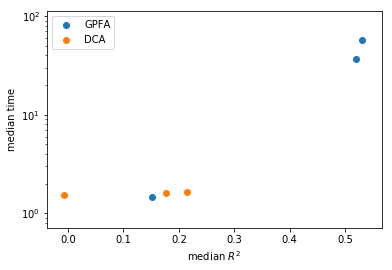

In [21]:
plt.scatter(np.median(r2[0, :, :, 1], axis=-1), np.median(times[0], axis=-1), label='GPFA')
plt.scatter(np.median(r2[1, :, :, 1], axis=-1), np.median(times[1], axis=-1), label='DCA')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(times.min() / 2, times.max() * 2)
plt.xlabel(r'median $R^2$')
plt.ylabel('median time')

In [ ]:
reload(mc)

gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=True, tol=1e-4)
gpfa.fit(X)

FA log likelihood: -8139.531780530168
EM update log likelihood: -5555.6964655277625

EM update log likelihood: -5154.244740881504

EM update log likelihood: -4748.679209087559

EM update log likelihood: -4483.9802472677275

EM update log likelihood: -4329.898610142343

EM update log likelihood: -4248.293533350408

EM update log likelihood: -4204.274048178426

EM update log likelihood: -4174.558065084444

EM update log likelihood: -4150.366841535451

EM update log likelihood: -4128.626931403697

EM update log likelihood: -4108.0875637017325

EM update log likelihood: -4087.620251213958

EM update log likelihood: -4066.05871663163

EM update log likelihood: -4042.757943340658



In [ ]:
reload(cca)
cca_model = cca.ComplexityComponentsAnalysis(d=2, T=5, n_init=5)
cca_model.estimate_cross_covariance(X, regularization='kron')

In [ ]:
cca_model.fit_projection()

In [ ]:
print(gpfa.C_)
print(subspace_angles(proj, gpfa.C_))
Xt = gpfa.transform(X)
model = LR().fit(X[:, :2], Xt)
model.score(X[:, :2], Xt)

In [ ]:
print(cca_model.coef_)
print(subspace_angles(proj, cca_model.coef_))
Xt = cca_model.transform(X)
model = LR().fit(X[:, :2], Xt)
model.score(X[:, :2], Xt)

In [51]:
reload(mc)
T, n, d = 100, 100, 3

X = np.random.randn(10 * n, n)
Rs =  np.cov(X, rowvar=False)
R = mc.make_block_diag(Rs, T)
X = np.random.randn(10 * T * d, T * d)
K =  np.cov(X, rowvar=False)
C =  np.random.randn(n, d)
C = mc.make_block_diag(C, T)
KCt = mc.block_dot_B(K, C.T, T)

def old(R, K, C, T):
    return np.linalg.solve((mc.block_dot_A(C, KCt, T) + R).T, KCt.T).T

def new(Rs, K, C, T):
    R_inv = mc.make_block_diag(np.linalg.inv(Rs), T)
    return KCt.dot(mc.matrix_inversion_identity(R_inv, K, C, T))

In [52]:
%timeit old(R, K, C, T)

10.1 s ± 446 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%timeit new(Rs, K, C, T)

4.19 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
np.allclose(old(R, K, C, T), new(Rs, K, C, T))

True